In [3]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 3080
1


In [4]:
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.utils import kaplan_meier

In [5]:
# Plot the time-depdendent ROC and calculate AUC
from sksurv.metrics import cumulative_dynamic_auc

In [6]:
import torch # For building the networks
import torchtuples as tt # Some useful functions

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
#import datetime
#import scipy.stats

%matplotlib inline
#plt.rc('font', family='NanumBarunGothic')
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore')

In [8]:
font_list = [font.name for font in fm.fontManager.ttflist]
plt.rcParams['font.family'] = 'Noto Sans KR'

In [9]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [10]:
train_dummies = pd.read_csv('train_B_dummy.csv')
val_dummies= pd.read_csv('val_B_dummy.csv')
test_dummies= pd.read_csv('test_B_dummy.csv')

In [11]:
X_train = train_dummies.drop(['delta', 'y'], axis=1)
#y_train = train_dummies['delta']

X_val = val_dummies.drop(['delta', 'y'], axis=1)
#y_val = val_dummies['delta']

X_test = test_dummies.drop(['delta', 'y'], axis=1)
#y_test = test_dummies['delta']

In [12]:
X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
X_test = X_test.values.astype('float32')

In [13]:
get_target = lambda df: (df['y'].values, df['delta'].values)
y_train = get_target(train_dummies)
y_val = get_target(val_dummies)
durations_test, events_test = get_target(test_dummies)
val = X_val, y_val

In [70]:
in_features = X_train.shape[1]
num_nodes = [1024, 1024]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [71]:
model = CoxPH(net, tt.optim.Adam)

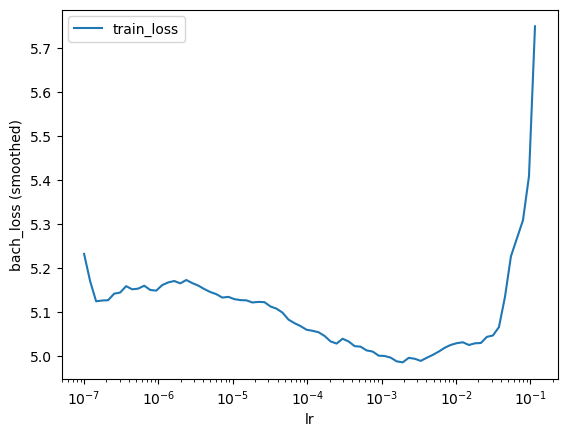

In [72]:
batch_size = 256
lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [73]:
lrfinder.get_best_lr()

0.0001917910261672496

In [74]:
model.optimizer.set_lr(0.0001)

In [75]:
epochs = 256
callbacks = [tt.callbacks.EarlyStopping(patience=20)]
verbose = True

In [76]:
%%time
log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[11s / 11s],		train_loss: 4.5166,	val_loss: 4.5559
1:	[11s / 22s],		train_loss: 4.4587,	val_loss: 4.5265
2:	[11s / 33s],		train_loss: 4.4346,	val_loss: 4.5120
3:	[11s / 45s],		train_loss: 4.4183,	val_loss: 4.5008
4:	[11s / 57s],		train_loss: 4.4044,	val_loss: 4.4929
5:	[12s / 1m:9s],		train_loss: 4.3930,	val_loss: 4.4816
6:	[12s / 1m:21s],		train_loss: 4.3829,	val_loss: 4.4773
7:	[11s / 1m:32s],		train_loss: 4.3744,	val_loss: 4.4749
8:	[11s / 1m:44s],		train_loss: 4.3660,	val_loss: 4.4680
9:	[12s / 1m:56s],		train_loss: 4.3586,	val_loss: 4.4596
10:	[11s / 2m:8s],		train_loss: 4.3511,	val_loss: 4.4600
11:	[11s / 2m:20s],		train_loss: 4.3453,	val_loss: 4.4489
12:	[11s / 2m:32s],		train_loss: 4.3401,	val_loss: 4.4479
13:	[11s / 2m:44s],		train_loss: 4.3325,	val_loss: 4.4432
14:	[11s / 2m:55s],		train_loss: 4.3281,	val_loss: 4.4389
15:	[11s / 3m:7s],		train_loss: 4.3241,	val_loss: 4.4380
16:	[11s / 3m:19s],		train_loss: 4.3176,	val_loss: 4.4334
17:	[11s / 3m:31s],		train_loss: 4.3133,	v

140:	[12s / 28m:8s],		train_loss: 4.0522,	val_loss: 4.3358
141:	[11s / 28m:20s],		train_loss: 4.0498,	val_loss: 4.3394
142:	[12s / 28m:32s],		train_loss: 4.0500,	val_loss: 4.3380
143:	[11s / 28m:44s],		train_loss: 4.0481,	val_loss: 4.3372
144:	[12s / 28m:56s],		train_loss: 4.0472,	val_loss: 4.3344
145:	[12s / 29m:8s],		train_loss: 4.0474,	val_loss: 4.3357
146:	[11s / 29m:20s],		train_loss: 4.0433,	val_loss: 4.3354
147:	[11s / 29m:32s],		train_loss: 4.0447,	val_loss: 4.3352
148:	[12s / 29m:44s],		train_loss: 4.0448,	val_loss: 4.3360
149:	[11s / 29m:56s],		train_loss: 4.0432,	val_loss: 4.3380
150:	[12s / 30m:8s],		train_loss: 4.0433,	val_loss: 4.3323
151:	[11s / 30m:20s],		train_loss: 4.0401,	val_loss: 4.3319
152:	[11s / 30m:32s],		train_loss: 4.0408,	val_loss: 4.3368
153:	[12s / 30m:44s],		train_loss: 4.0394,	val_loss: 4.3349
154:	[12s / 30m:56s],		train_loss: 4.0382,	val_loss: 4.3414
155:	[11s / 31m:8s],		train_loss: 4.0372,	val_loss: 4.3325
156:	[11s / 31m:20s],		train_loss: 4.0349,	v

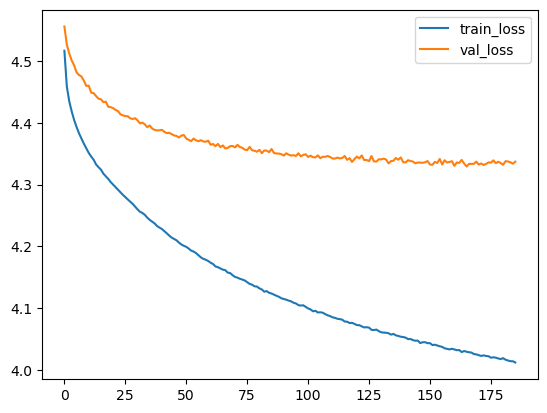

In [77]:
_ = log.plot()

In [78]:
_ = model.compute_baseline_hazards()

In [79]:
surv = model.predict_surv_df(X_test)

In [80]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [81]:
# num_nodes = [1024, 1024]
# earlystopping = patience=20
# batch_size = 256
# dropout = 0.1
# lr = 0.0001
# epoch = 256
ev.concordance_td()

0.8063330792721948

In [16]:
import dill

In [84]:
with open('C:/Users/user/desktop/kopis/ds_gB.pkl', 'wb') as f:
    dill.dump(model, f)

In [17]:
with open('C:/Users/user/desktop/kopis/ds_gB.pkl', 'rb') as f:
    modelB = dill.load(f)

In [18]:
_ = modelB.compute_baseline_hazards()
surv = modelB.predict_surv_df(X_test)

In [47]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

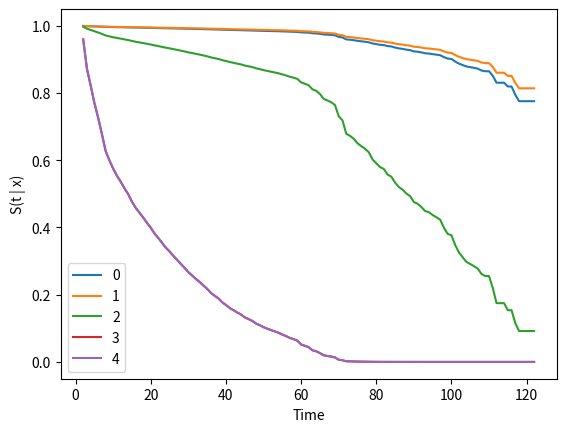

In [19]:
surv.iloc[:, :5].plot()
#surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
test_dummies['y'].describe()

count    121867.000000
mean         20.936176
std          18.291580
min           2.000000
25%           4.000000
50%          16.000000
75%          33.000000
max         122.000000
Name: y, dtype: float64

<AxesSubplot:>

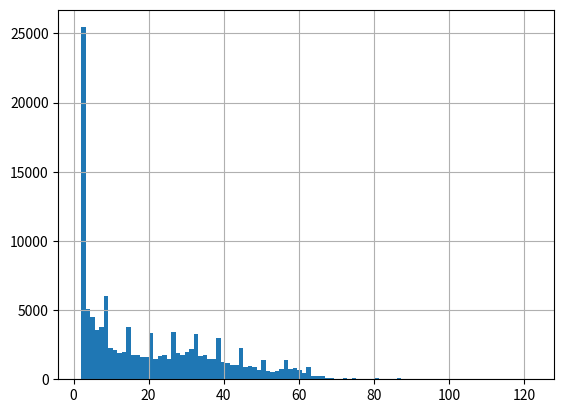

In [41]:
test_dummies['y'].hist(bins=100)

In [21]:
y_test = np.array(list(zip(test_dummies['delta'], test_dummies['y'])), dtype=[('death', 'bool'),('futime', 'int')])

In [22]:
y_train = np.array(list(zip(train_dummies['delta'], train_dummies['y'])), dtype=[('death', 'bool'),('futime', 'int')])

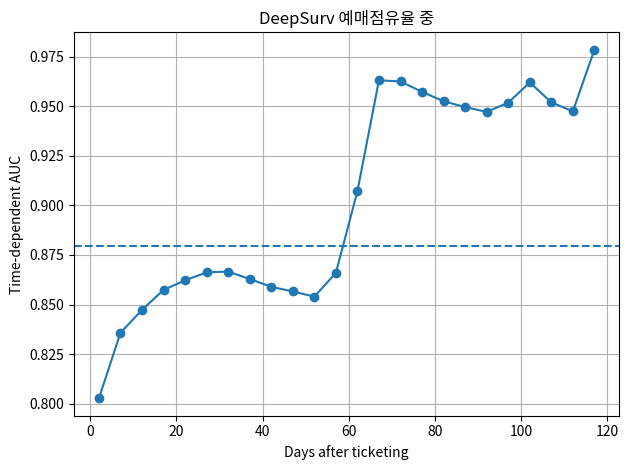

In [43]:
time_interval = np.arange(2, 122, 5)

cph_risk_scores = modelB.predict(X_test).ravel()
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, time_interval)

fig, ax = plt.subplots()

ax.plot(time_interval, cph_auc, marker='o')
ax.axhline(cph_mean_auc, ls='--')
ax.set_xlabel('Days after ticketing')
ax.set_ylabel('Time-dependent AUC')
plt.title('DeepSurv 예매점유율 중')

plt.grid(True)
plt.tight_layout()

In [50]:
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import brier_score

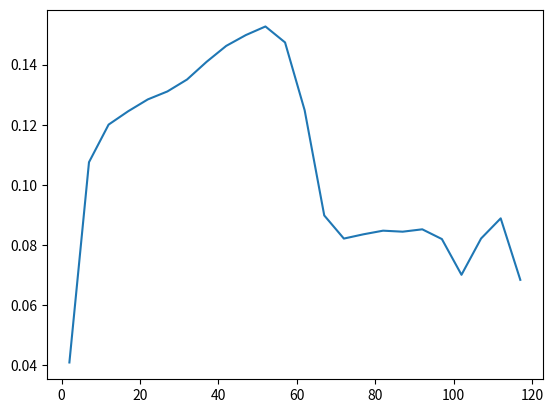

In [68]:
#time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_interval).plot()

In [70]:
ev.brier_score(time_interval)

2      0.040778
7      0.107504
12     0.120028
17     0.124483
22     0.128423
27     0.131078
32     0.135046
37     0.140954
42     0.146255
47     0.149854
52     0.152719
57     0.147405
62     0.124808
67     0.089762
72     0.082056
77     0.083481
82     0.084689
87     0.084351
92     0.085141
97     0.081897
102    0.069986
107    0.082085
112    0.088794
117    0.068309
Name: brier_score, dtype: float64

In [71]:
time_interval

array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117])

In [76]:
train_dummies.loc[train_dummies['delta']==1, 'y'].drop_duplicates().sort_values().values

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 111, 112, 115, 117, 118], dtype=int64)

In [77]:
ev.integrated_brier_score(train_dummies.loc[train_dummies['delta']==1, 'y'].drop_duplicates().sort_values().values)

0.10872916508492732